In [1]:
model_name = 'Mode_Global'
mode_range = 100

In [2]:
import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.random.set_seed(10)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import matplotlib.pyplot as plt

In [3]:
raw_train = np.load('../Grid_LSTM/POD/train_z500_coeffs.npy').T[:,:mode_range]
raw_test = np.load('../Grid_LSTM/POD/train_z500_coeffs.npy').T[:,:mode_range]

In [4]:
scaler = MinMaxScaler()
train_coeffs = scaler.fit_transform(raw_train)
test_coeffs = scaler.transform(raw_test)

In [5]:
input_window = 14
output_window = 7

train_inputs = []
train_outputs = []

i = 0
while i < train_coeffs.shape[0] - input_window - output_window:
    train_inputs.append(train_coeffs[i:i+input_window])
    train_outputs.append(train_coeffs[i+input_window:i+input_window+output_window])
    i = i + 1
    
train_inputs = np.asarray(train_inputs)
train_outputs = np.asarray(train_outputs)

In [6]:
embed_dim = train_inputs[0].shape[-1]
output_dim = train_outputs[0].shape[-1]
encode_dim = 10

In [7]:
ff_dim = 50  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.0

inputs = layers.Input(shape=(input_window,embed_dim))
encoding_layer = layers.TimeDistributed(layers.Dense(encode_dim))

lstm_layer_1 = layers.Bidirectional(layers.LSTM(ff_dim,activation='relu'))
lstm_layer_2 = layers.RepeatVector(output_window)
lstm_layer_3 = layers.LSTM(encode_dim,return_sequences=True,activation='relu')

decoding_layer = layers.TimeDistributed(layers.Dense(output_dim))

encoded = encoding_layer(inputs)
x = lstm_layer_1(encoded)
x = lstm_layer_2(x)
x = lstm_layer_3(x)
outputs = decoding_layer(x)


print(tf.shape(outputs))

outputs_enc = decoding_layer(encoded)


model = tf.keras.Model(inputs=inputs, outputs=[outputs,outputs_enc])

KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 7, 100], name='tf.compat.v1.shape/Shape:0', description="created by layer 'tf.compat.v1.shape'")


In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss',patience=20)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14, 100)]    0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 14, 10)       1010        input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100)          24400       time_distributed[0][0]           
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 7, 100)       0           bidirectional[0][0]              
______________________________________________________________________________________________

In [10]:
history = model.fit(train_inputs,[train_outputs,train_inputs],epochs=40,batch_size=256,callbacks=[reduce_lr,early_stop],validation_split=0.2)

Epoch 1/40
40/40 [==============================] - 4s 41ms/step - loss: 0.4997 - time_distributed_1_loss: 0.2436 - time_distributed_1_1_loss: 0.2561 - val_loss: 0.2764 - val_time_distributed_1_loss: 0.1523 - val_time_distributed_1_1_loss: 0.1241
Epoch 2/40
40/40 [==============================] - 1s 22ms/step - loss: 0.2065 - time_distributed_1_loss: 0.1156 - time_distributed_1_1_loss: 0.0909 - val_loss: 0.0724 - val_time_distributed_1_loss: 0.0421 - val_time_distributed_1_1_loss: 0.0303
Epoch 3/40
40/40 [==============================] - 1s 22ms/step - loss: 0.0571 - time_distributed_1_loss: 0.0326 - time_distributed_1_1_loss: 0.0246 - val_loss: 0.0322 - val_time_distributed_1_loss: 0.0159 - val_time_distributed_1_1_loss: 0.0163
Epoch 4/40
40/40 [==============================] - 1s 24ms/step - loss: 0.0292 - time_distributed_1_loss: 0.0139 - time_distributed_1_1_loss: 0.0153 - val_loss: 0.0261 - val_time_distributed_1_loss: 0.0117 - val_time_distributed_1_1_loss: 0.0144
Epoch 5/40
4

40/40 [==============================] - 1s 35ms/step - loss: 0.0213 - time_distributed_1_loss: 0.0109 - time_distributed_1_1_loss: 0.0104 - val_loss: 0.0218 - val_time_distributed_1_loss: 0.0112 - val_time_distributed_1_1_loss: 0.0106
Epoch 35/40
40/40 [==============================] - 1s 32ms/step - loss: 0.0213 - time_distributed_1_loss: 0.0109 - time_distributed_1_1_loss: 0.0104 - val_loss: 0.0217 - val_time_distributed_1_loss: 0.0112 - val_time_distributed_1_1_loss: 0.0105
Epoch 36/40
40/40 [==============================] - 1s 35ms/step - loss: 0.0212 - time_distributed_1_loss: 0.0109 - time_distributed_1_1_loss: 0.0103 - val_loss: 0.0216 - val_time_distributed_1_loss: 0.0111 - val_time_distributed_1_1_loss: 0.0105
Epoch 37/40
40/40 [==============================] - 2s 40ms/step - loss: 0.0212 - time_distributed_1_loss: 0.0109 - time_distributed_1_1_loss: 0.0103 - val_loss: 0.0216 - val_time_distributed_1_loss: 0.0111 - val_time_distributed_1_1_loss: 0.0104
Epoch 38/40
40/40 [=

In [11]:
pred_outputs, pred_reconstructed = model.predict(train_inputs)

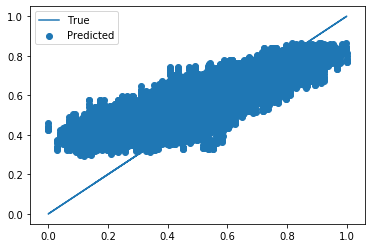

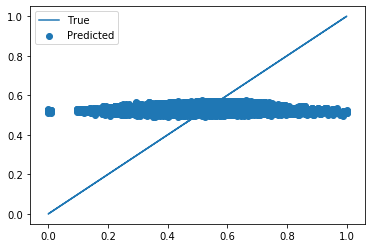

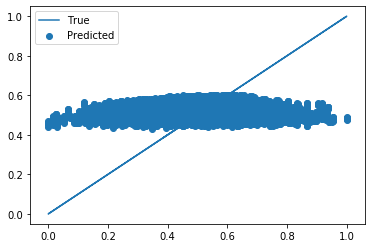

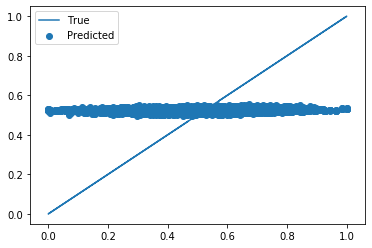

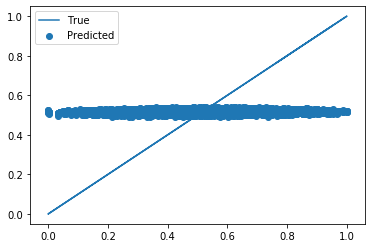

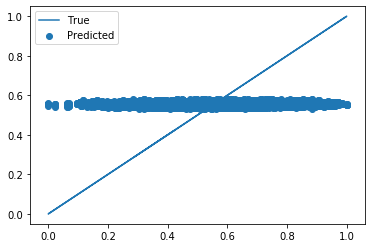

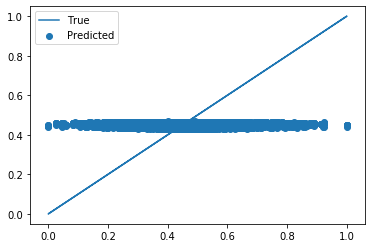

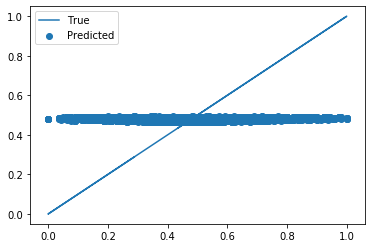

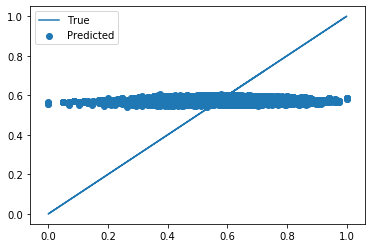

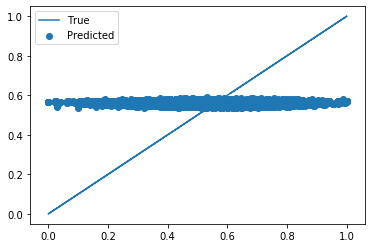

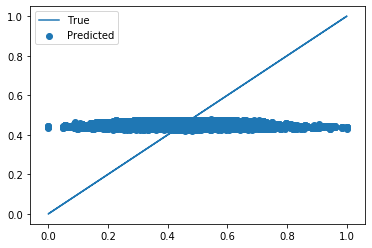

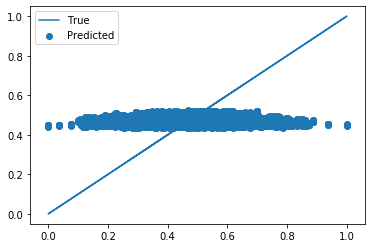

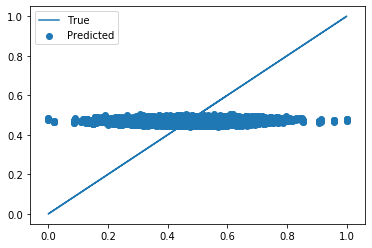

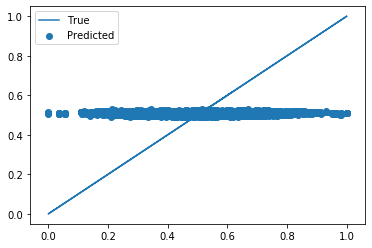

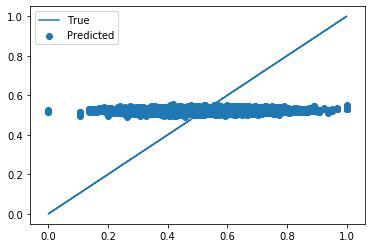

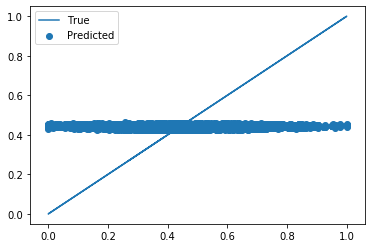

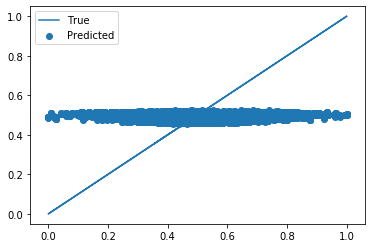

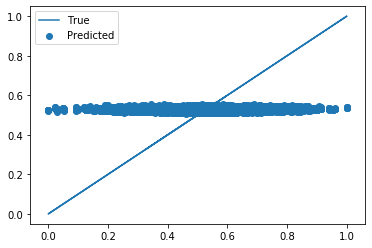

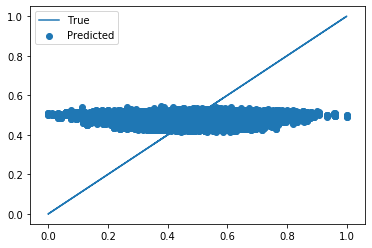

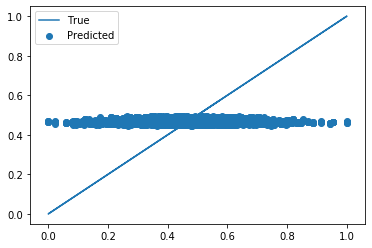

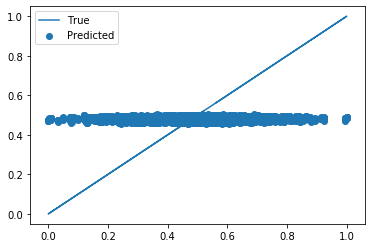

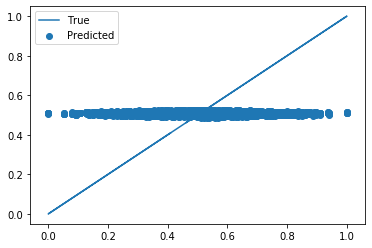

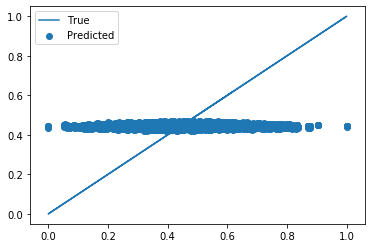

KeyboardInterrupt: 

In [12]:
for mode_num in range(mode_range):
    plt.figure()
    plt.plot(train_outputs[:,:,mode_num].flatten(),train_outputs[:,:,mode_num].flatten(),label='True')
    plt.scatter(train_outputs[:,:,mode_num].flatten(),pred_outputs[:,:,mode_num].flatten(),label='Predicted')
    plt.legend()
    plt.show()

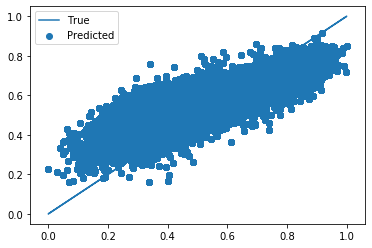

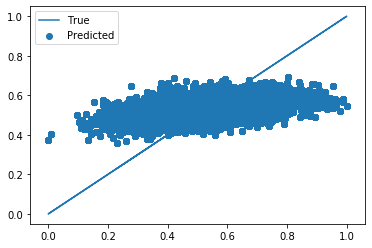

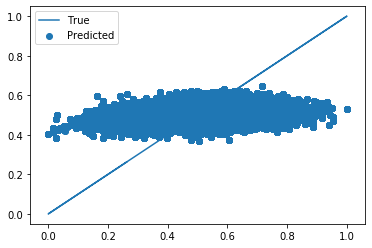

KeyboardInterrupt: 

In [13]:
for mode_num in range(mode_range):
    plt.figure()
    plt.plot(train_inputs[:,:,mode_num].flatten(),train_inputs[:,:,mode_num].flatten(),label='True')
    plt.scatter(train_inputs[:,:,mode_num].flatten(),pred_reconstructed[:,:,mode_num].flatten(),label='Predicted')
    plt.legend()
    plt.show()